In this notebook, we read the pixels of the noisy image with modified space-filling curve. We then apply the fast Fourier transform of the one-dimensional signal obtained by passing an input picture with modified Sierpinski space-filling curve. We use periodic space-filling curve because Fourier transform assumes the transformed signal to be periodic. Our goal is to see whether using lower harmonics will be enough to capture most of image information and obtain more clear image.

We write a function that can be used to read an image with modified Sierpinski space-filling curve. 

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import copy

%matplotlib inline

# N is the order of the curve (see sierpinski.ipynb for details)
def modified_sierpinski_curve(N, plot_curve = True):
    #initialize arrays
    dx = np.zeros(2**(2*N), dtype=int)
    dy = np.zeros(2**(2*N), dtype=int)
    x = np.zeros(2**(2*N), dtype=int)
    y = np.zeros(2**(2*N), dtype=int)
    
    # directions of curve 
    dx[0:8] = [1, 0, 1, 1, 0, -1, 1, 0] 
    dy[0:8] = [0, -1, 1, 0, -1, 0, -1, -1]
    
    #building fractal curve
    for n in range(2,N):
        dx[2**(2*n-1):2**(2*n)] = -dy[0:2**(2*n-1)]
        dy[2**(2*n-1):2**(2*n)] = dx[0:2**(2*n-1)]
        dx[2**(2*n-1)] = 1
        dy[2**(2*n-1)] = 1
        dx[2**(2*n):2**(2*n+1)] = dy[0:2**(2*n)]
        dy[2**(2*n):2**(2*n+1)] = -dx[0:2**(2*n)]
    

    dx[2**(2*N-1):2**(2*N)] = -dx[0:2**(2*N-1)]
    dy[2**(2*N-1):2**(2*N)] = -dy[0:2**(2*N-1)]

    for i in range(2**(2*N)-1):
        x[i+1] = x[i] + dx[i]
        y[i+1] = y[i] + dy[i]
    
    if plot_curve:
        plt.plot(x,y)
        plt.show()
        
    return x, y

Let's produce a gray noisy image from the original color image.

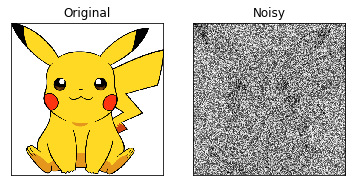

In [33]:
original = cv2.imread("images/pika.png",cv2.IMREAD_COLOR) 
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB) # OpenCV uses BGR as its default colour order for images, matplotlib uses RGB
                                                     # we need to conver it back to RGB

img = cv2.imread("images/pika.png",cv2.IMREAD_GRAYSCALE) # convert RGB image to gray
noised = (img + 1000 * np.random.rand(*img.shape).astype(np.float32)) # add Gaussian noise


plt.subplot(121),plt.imshow(original),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(noised, cmap = 'gray'),plt.title('Noisy')
plt.xticks([]), plt.yticks([])
plt.show()

To cover every pixel of the image we read the image with the curve of the order $N = log_{10}(numbers\_of\_pixels)/log_{10}(2)$. 

In [34]:
img = noised
image = np.array(img)
num_px = image.shape[0] #square image
print("The size of the image is: " + str(image.shape))
N = math.log10(num_px) / math.log10(2)
N = int(N)
print("The order of the curve N = " + str(N))

x, y = modified_sierpinski_curve(N, plot_curve=False) # read with the curve
data = np.zeros((2**(2*N)), dtype=int)
for i in range(2**(2*N)-1):
    data[i] = image[-y[i],x[i]]

The size of the image is: (512, 512)
The order of the curve N = 9


We then apply discrete Fourier transform:
$$A_t = \sum_{k=0}^{K-1} a_k \cdot e^{-\frac{i 2\pi}{K} kt},$$
where $a_k$ are Fourier coefficients which represent signal values in the frequency domain.
The image can be decomposed into a weighted sum of sinusoids and cosinuoids of different frequency: 
$$A_t = \sum_{k=0}^{K-1} a_k \cdot [cos(2\pi kt/K)-i\cdot sin(2\pi kt/K)]$$

Due to the property of Fourier expansions, higher Fourier harmonics carry less information about the data than lower harmonics. We select subset of the $m/2$ lowest positive-frequency terms and the $m/2$ lowest negative-frequency terms.

number of modes: 131073
select first 1000 modes
select last 1000 modes


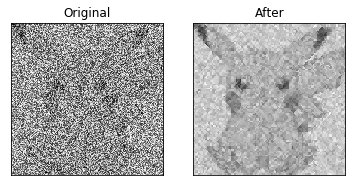

In [35]:
# numpy fft: 
# if A = fft(a, n), then A[0] contains the zero-frequency term (the sum of the signal).
# Then A[1:n/2] contains the positive-frequency terms, and A[n/2+1:] contains the negative-frequency terms, in order of decreasingly negative frequency. 
# For an even number of input points, A[n/2] represents both positive and negative frequency, and is also purely real for real input. 
# For an odd number of input points, A[(n-1)/2] contains the largest positive frequency, while A[(n+1)/2] contains the largest negative frequency.
f = np.fft.rfft(data)
print("number of modes: " + str(len(f))) 
m = 2000 # total number of modes
i1 = 0
i2 = int(m/2 + 1)
i3 = len(f) - i2
i4 = len(f) - i1 - 1 
print("select first " + str(i2-1) + " modes")
print("select last " + str(len(f) - i3 - 1) + " modes")
f[i2:i3] = 0.0


# inverse Fourier transform    
d  = np.fft.irfft(f, len(data))
# get image back
img_back = copy.deepcopy(img)
for ii in range(2**(2*N)-1):
    img_back[-y[ii],x[ii]] = d[ii].real

plt.subplot(121),plt.imshow(img, cmap = 'gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray'),plt.title('After')
plt.xticks([]), plt.yticks([])
plt.show()

Because first $m$ positive-frequency terms and last $m$ negative-frequency terms are complex conjugates, we even can only consider first $m$ positive-frequency terms.

number of modes: 131073
select first 1000 modes


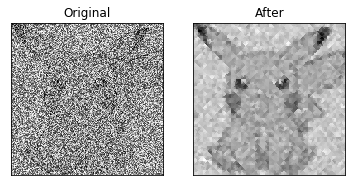

In [31]:
f = np.fft.rfft(data)
print("number of modes: " + str(len(f))) 
m = 1000 # total number of modes
print("select first " + str(m) + " modes")
f[(m+1):(len(f)-1)] = 0.0


# inverse Fourier transform    
d  = np.fft.irfft(f, len(data))
# get image back
img_back = copy.deepcopy(img)
for ii in range(2**(2*N)-1):
    img_back[-y[ii],x[ii]] = d[ii].real

plt.subplot(121),plt.imshow(img, cmap = 'gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray'),plt.title('After')
plt.xticks([]), plt.yticks([])
plt.show()